In [127]:
from face import load_face_dataset

from sklearn.metrics import f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import scipy.stats as stats
import numpy as np
import math
import imutils
import time
import cv2
import os
from tqdm import tqdm

**Note** : If you save the model, model file will take about `~1.2GB` of your memory. So be careful if you want to save it.

In [128]:
def cross_validation(input_data , cv = 5 , test_size = 0.20 , output = True , save_model=False):

  # initialize the f1-scores list
  f1_scores = []
  # grab some random numbers between 0 and 100
  random_states = np.random.randint(low = 0, high = 100 , size = cv , dtype = int)

  # extract faces and label from dataset
  (faces , labels) = load_face_dataset(input_data , minSamples=15)

  # encode the labels
  le = LabelEncoder()
  labels = le.fit_transform(labels)

  # do the training process based on the number of 
  # random_states

  print(f"Training the model with cross validation = {cv}")
  for random_state in tqdm(random_states):
    # split the data into training and test set
    X_train , X_test , y_train , y_test = train_test_split(faces , labels , test_size = test_size,
                                                          stratify = labels , random_state = random_state)
    
    # define and train the LBP model
    recognizer = cv2.face.LBPHFaceRecognizer_create(
        radius = 3 , neighbors = 12 , grid_x = 12 , grid_y  = 12)

    recognizer.train(X_train , y_train)

    # initialize our predictions and confidence lists
    predictions = []
    confidence = []

    # loop over the test data
    for i in range(0 , len(X_test)):
      # classify the face and update the predictions
      # and confidence scores
      (prediction , conf) = recognizer.predict(X_test[i])
      predictions.append(prediction)
      confidence.append(confidence)

    # collect and append the calculated f1-score based on this
    # random state
    # Calculate Accuracy
    accuracy = accuracy_score(y_test, predictions)
    f1_scores.append(f1_score(y_test,predictions,average="macro"))

  # convert the f1-scores list into Numpy array
  f1_scores = np.array(f1_scores , dtype="float32")
  accuracy_scores = np.array(accuracy , dtype="float32")

  if output:
    # generate a sample of testing data
    idxs = np.random.choice(range(0 , len(X_test)) , size = 10 , replace = False)

    for i in idxs:
      # grab the actual and predicted name
      predName = le.inverse_transform([predictions[i]])[0]
      actualName = le.classes_[y_test[i]]

      # grab the face image, convert back it from 1 channel
      # into 3 channels and then resize it
      face = np.dstack([X_test[i]] * 3)
      face = imutils.resize(face , width = 250)

      # draw the actual and predicted name on the image
      cv2.putText(face , "actual : {}".format(actualName) , (5 , 25),
                  cv2.FONT_HERSHEY_SIMPLEX , 0.8 , (0 , 0 , 255) , 2)
      cv2.putText(face , "prediction : {}".format(predName) , (5 , 60),
                  cv2.FONT_HERSHEY_SIMPLEX , 0.8 , (0 , 255 , 0) , 2)
      
      # display the result image and the save it into
      # the desired directory 
      plt.imshow(face , cmap="gray")
      plt.savefig("output/lbp-faces/face-{}.png".format(i))
    # save the model 
  
  print("Saving the model")
  if save_model:
    # save the model 
    recognizer.save("face-gender-model.yml")

  return f1_scores, accuracy_scores

In [129]:
def cross_validation_with_rf(input_data , cv = 5 , test_size = 0.20 , output = True , save_model=False):

  # initialize the f1-scores list
  f1_scores = []
  # grab some random numbers between 0 and 100
  random_states = np.random.randint(low = 0, high = 100 , size = cv , dtype = int)

  # extract faces and label from dataset
  (faces , labels) = load_face_dataset(input_data , minSamples=15)

  # encode the labels
  le = LabelEncoder()
  labels = le.fit_transform(labels)

  # do the training process based on the number of 
  # random_states

  print(f"Training the model with cross validation = {cv}")
  from sklearn.ensemble import RandomForestClassifier
  from skimage import feature
  import xgboost as xgb
    
  for random_state in tqdm(random_states):
        X_train , X_test , y_train , y_test = train_test_split(faces , labels , test_size = test_size,
                                                          stratify = labels , random_state = random_state)
        
        # Replace LBPH recognizer with LBP feature extraction
        lbp_features = []
        for face in X_train:
            # Calculate LBP features
            radius = 3
            n_points = 8 * radius
            lbp = feature.local_binary_pattern(face, n_points, radius, method='uniform')
            # Convert LBP image to feature vector (histogram)
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3), 
                                 range=(0, n_points + 2))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-7)  # Normalize
            lbp_features.append(hist)
            
        # Train Random Forest on LBP features
        rf_classifier = xgb.XGBClassifier(objective="binary:logistic", random_state=random_state)
        rf_classifier.fit(lbp_features, y_train)
        
        # Extract features from test set
        test_features = []
        for face in X_test:
            lbp = feature.local_binary_pattern(face, n_points, radius, method='uniform')
            hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, n_points + 3),
                                 range=(0, n_points + 2))
            hist = hist.astype("float")
            hist /= (hist.sum() + 1e-7)
            test_features.append(hist)
            
        # Make predictions using Random Forest
        predictions = rf_classifier.predict(test_features)
        
        # Calculate metrics
        accuracy_scores = accuracy_score(y_test, predictions)
        f1_scores.append(f1_score(y_test, predictions, average="macro"))

  if output:
    # generate a sample of testing data
    idxs = np.random.choice(range(0 , len(X_test)) , size = 10 , replace = False)

    for i in idxs:
      # grab the actual and predicted name
      predName = le.inverse_transform([predictions[i]])[0]
      actualName = le.classes_[y_test[i]]

      # grab the face image, convert back it from 1 channel
      # into 3 channels and then resize it
      face = np.dstack([X_test[i]] * 3)
      face = imutils.resize(face , width = 250)

      # draw the actual and predicted name on the image
      cv2.putText(face , "actual : {}".format(actualName) , (5 , 25),
                  cv2.FONT_HERSHEY_SIMPLEX , 0.8 , (0 , 0 , 255) , 2)
      cv2.putText(face , "prediction : {}".format(predName) , (5 , 60),
                  cv2.FONT_HERSHEY_SIMPLEX , 0.8 , (0 , 255 , 0) , 2)
      
      # display the result image and the save it into
      # the desired directory 
      plt.imshow(face , cmap="gray")
      plt.savefig("output/lbp-faces/face-{}.png".format(i))
    # save the model 
  
  # print("Saving the model")
  # if save_model:
  #   # save the model 
  #   recognizer.save("face-gender-model.yml")

  return f1_scores, accuracy_scores

Number of images:  446


100%|██████████| 446/446 [00:00<00:00, 5762.54it/s]


Training the model with cross validation = 5


100%|██████████| 5/5 [00:02<00:00,  2.28it/s]


The mean of f1-scores is :  0.6810049967970452
The mean of accuracy is :  0.6444444444444445


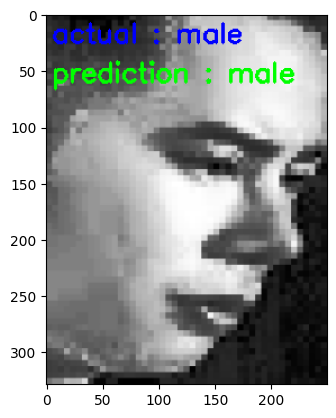

In [130]:
f1_scores, accuracy_scores = cross_validation_with_rf("gender" , cv=5 , save_model=True)
mu = np.mean(f1_scores)
print("The mean of f1-scores is : " , mu)
accuracy = np.mean(accuracy_scores)
print("The mean of accuracy is : " , accuracy)


In [131]:
# grab the mean of f1-scores
mu = np.mean(f1_scores)
# grab the standard deviation o f f1-scores
sigma = np.std(f1_scores)

print("The mean of f1-scores is : " , mu)
print("The standard deviation of f1-scores is : " , sigma)

# Calculate Accuracy
accuracy = np.mean(accuracy_scores)
print("The mean of accuracy is : " , accuracy)

The mean of f1-scores is :  0.6810049967970452
The standard deviation of f1-scores is :  0.03817162432497767
The mean of accuracy is :  0.6444444444444445


In [132]:
# recognizer = cv2.face.LBPHFaceRecognizer_create(
#     radius = 3 , neighbors = 12 , grid_x = 12 , grid_y  = 12)

# recognizer.read("face-gender-model.yml")

In [133]:
# img = cv2.imread("vietnamese-celebrity-faces/die╠В╠Гn vie╠Вn Vu╠Ыo╠Ыng Tu╠Ы╠Й Va╠Жn/1671998048631800000.jpg")
# img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# (prediction , conf) = recognizer.predict(img)

# print(prediction)